# McNulty Challenges
###Supervised Learning

In [2]:
# python frameworks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn packages

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

In [3]:
# download congressional vote data

!curl https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data > "house-vote-84.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18171  100 18171    0     0  22062      0 --:--:-- --:--:-- --:--:-- 22052


### Challenge 1 

Load the data into a pandas dataframe. Replace 'y's with 1s, 'n's with 0s.

Now, almost every representative has a ?. This represents a no vote (they were absent or some other similar reason). If we dropped all the rows that had a ?, we would throw out most of our data. Instead, we will replace ? with the best guess in the Bayesian sense: in the absence of any other information, we will say that the probability of the representative saying YES is the ratio of others that said YES over the whole votes.

So, convert each ? to this probability (when yes=1 and no=0, this is the mean of the column)

In [4]:
# read file into pandas dataframe

with open("house-vote-84.txt") as f:
    house_data = pd.read_csv(f, header = None)
    
column_names = ["party"]
column_names.extend(list(range(1,17)))

house_data.columns = column_names

In [5]:
# convert all data to numeric: y -> 1 ; n -> 0 ; ? -> avg vote

house_data = house_data.replace("y", 1).replace("n", 0).replace("?", np.nan)
for column in house_data.columns[1:]:
    house_data[column] = house_data[column].replace(np.nan, house_data[column].mean())

###Challenge 2

Split the data into a test and training set. But this time, use this function:

```python
from sklearn.cross_validation import train_test_split
```

In [6]:
# divide data into predictor (votes) and outcome (party)
# create training and test data partitions

party = house_data["party"]
votes = house_data.loc[:, 1:]

train_input, test_input, train_outcome, test_outcome = train_test_split(votes, party, test_size = 0.33, random_state = 42)

###Challenge 3

Using scikit.learn's KNN algorithm, train a model that predicts the party (republican/democrat):

```python
from sklearn.neighbors import KNeighborsClassifier
```
Try it with a lot of different k values (number of neighbors), from 1 to 20, and on the test set calculate the accuracy (number of correct predictions / number of all predictions) for each k

You can use this to calculate accuracy:

```python
from sklearn.metrics import accuracy_score
```
Which k value gives the highest accuracy?

In [7]:
# find accuracy of knn with different k's
# find k that gives the max accuracy

def accuracy_knn(k):
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(train_input, train_outcome)
    test_pred = neigh.predict(test_input)
    return accuracy_score(test_outcome, test_pred)

accuracies = []
for k in range(1, 21):
    accuracies.append(accuracy_knn(k))
    
max_acc_k = max(accuracies)
for i,j in enumerate(accuracies):
    if j == max_acc_k:
        print "optimal k: " + str(i+1) + " ------" + " knn accuracy: " + str(j)

optimal k: 3 ------ knn accuracy: 0.951388888889
optimal k: 5 ------ knn accuracy: 0.951388888889


###Challenge 4

Make a similar model but with LogisticRegression instead, calculate test accuracy.

In [8]:
# find accuracy of logistic regression mode

log_reg = LogisticRegression()
log_reg.fit(train_input, train_outcome)
test_predict = log_reg.predict(test_input)
log_acc = accuracy_score(test_outcome, test_predict)
print "logistic regression accuracy: " + str(log_acc)

logistic regression accuracy: 0.972222222222


###Challenge 5

Make a bar graph of democrats and republicans. How many of each are there?

Make a very simple predictor that predicts 'democrat' for every incoming example.

Just make a function that takes in an X --an array or matrix with input examples--, and returns an array of the same length as X, where each value is 'democrat'. For example, if X is three rows, your function should return ['democrat','democrat','democrat']. Make a y_predicted vector using this and measure its accuracy.

Do the same with predicting 'republican' all the time and measure its accuracy.

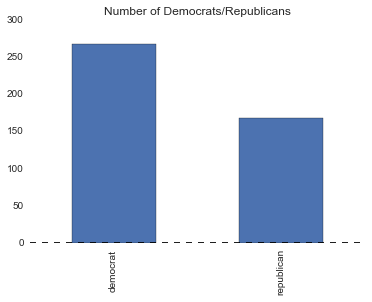

In [9]:
# create a bar plot of outcome variable

party_bar = house_data["party"].value_counts().plot(kind = "bar", title = "Number of Democrats/Republicans")

In [10]:
# return an array (same # rows as dataframe) with all democrats
# return an array (same # rows as dataframe) with all republicans

def all_dems(data_array):
    return ["democrat"] * len(data_array)

def all_reps(data_array):
    return ["republican"] * len(data_array)

In [11]:
# calculate accuracy of guessing all democrats
# calculate accuracy of guessing all republicans

dem_predict = all_dems(test_outcome)
dem_acc = accuracy_score(test_outcome, dem_predict)
rep_predict = all_reps(test_outcome)
rep_acc = accuracy_score(test_outcome, rep_predict)
print "accuracy by guessing all democrats: " + str(dem_acc)
print "accuracy by guessing all republicans: " + str(rep_acc)

accuracy by guessing all democrats: 0.673611111111
accuracy by guessing all republicans: 0.326388888889


###Challenge 6

Plot the accuracies as a function of k. Since k only matters for KNN, your logistic regression accuracy, 'democrat' predictor accuracy and 'republican' predictor accuracy will stay the same over all k, so each of these three will be a horizontal line. But the KNN accuracy will change with k.

In [12]:
# create a dataframe with accuracies using different methods

diff_accs = pd.DataFrame(accuracies, index = range(1,21))
diff_accs.columns = ["knn"]
diff_accs["logistic"] = log_acc
diff_accs["all_democrats"] = dem_acc
diff_accs["all_republicans"] = rep_acc

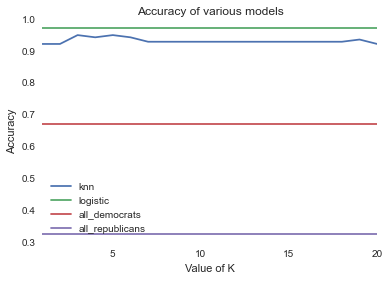

In [13]:
# plot accuracy of different predictors 

ax = diff_accs.plot(title = "Accuracy of various models")
ax.set_xlabel("Value of K")
ax.set_ylabel("Accuracy")

###Challenge 7

Plot a learning curve for the logistic regression model. But instead of going through the painstaking steps of doing it yourself, use this function:

```python
from sklearn.learning_curve import learning_curve
```
This will give you the m, training errors and testing errors. All you need to do is plot them. You don't even need to give it separate training/test sets. It will do crossvalidation all by itself. Easy, isn't it? : ) Remember, since it does cross-validation, it doesn't have a single training error or test error per m value. Instead, it has one for each fold (separate partition) of the cross validation. A good idea is to take the mean of these errors from different folds. This gives you a meaningful single number per m. What I mean is that doing something like:
```python
train_cv_err = np.mean(train_err,axis=1)
test_cv_err = np.mean(ts_err,axis=1)
```
Before plotting m vs train_cv_err and m vs test_cv_err, where train_err and test_err are the vectors returned by the learning curve function. The np.mean(...., axis=1) means take the mean along axis 1 (axis 1 is the columns axis-- for each row, you have a bunch of columns, each corresponding to a cross validation fold, you are averaging these columns for each row).

Draw the learning curve for KNN with the best k value as well.

In [14]:
# calculate training and test set errors
# calculate the mean of errors for each cv-fold

log_train_sizes, log_train_scores, log_test_scores = learning_curve(LogisticRegression(), votes, party)

log_train_cv_err = np.mean(log_train_scores,axis=1)
log_test_cv_err = np.mean(log_test_scores,axis=1)

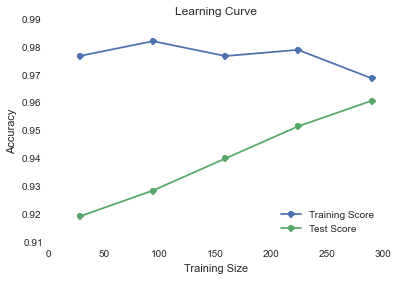

In [15]:
# create a learning curve of a logistic regression model

plt.figure()
plt.plot(log_train_sizes, log_train_cv_err, 'o-', label = "Training Score")
plt.plot(log_train_sizes, log_test_cv_err, 'o-', label = "Test Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")

In [16]:
# calculate training and test set errors
# calculate the mean of errors for each cv-fold

knn_train_sizes, knn_train_scores, knn_test_scores = learning_curve(KNeighborsClassifier(n_neighbors=5), votes, party)

knn_train_cv_err = np.mean(knn_train_scores,axis=1)
knn_test_cv_err = np.mean(knn_test_scores,axis=1)

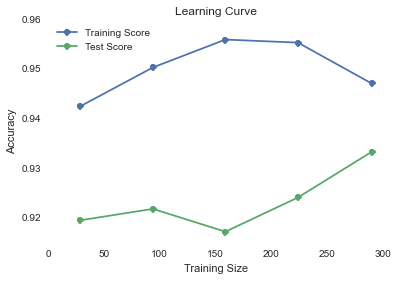

In [17]:
# create a learning curve of a logistic regression model

plt.figure()
plt.plot(knn_train_sizes, knn_train_cv_err, 'o-', label = "Training Score")
plt.plot(knn_train_sizes, knn_test_cv_err, 'o-', label = "Test Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")

###Challenge 8

This is a preview of many other classification algorithms that we will go over. Scikit.learn has the same interface for all of these, so you can use them exactly the same way as you did LogisticRegression and KNeighborsClassifier. Use each of these to classify your data and print the test accuracy of each:

Gaussian Naive Bayes

```python
from sklearn.naive_bayes import GaussianNB
```
SVM (Support Vector Machine) Classifier
```python
from sklearn.svm import SVC
```
Decision Tree
```python
from sklearn.tree import DecisionTreeClassifier
```
Random Forest
```python
from sklearn.ensemble import RandomForestClassifier
```

In [18]:
# find accuracy of model using Gaussian Naive Bayes

GNB = GaussianNB()
GNB.fit(train_input, train_outcome)
GNB_test_predict = GNB.predict(test_input)
GNB_acc = accuracy_score(test_outcome, GNB_test_predict)
print "Gaussian Naive Bayes accuracy: " + str(GNB_acc)

Gaussian Naive Bayes accuracy: 0.930555555556


In [19]:
# find accuracy of model using Support Vector Machines

SVM_c = SVC()
SVM_c.fit(train_input, train_outcome)
SVM_c_test_predict = SVM_c.predict(test_input)
SVM_c_acc = accuracy_score(test_outcome, SVM_c_test_predict)
print "Support Vector Machine classifier accuracy: " + str(SVM_c_acc)

Support Vector Machine classifier accuracy: 0.965277777778


In [20]:
# find accuracy of model using a Decision Tree

dtree = DecisionTreeClassifier()
dtree.fit(train_input, train_outcome)
dtree_test_predict = dtree.predict(test_input)
dtree_acc = accuracy_score(test_outcome, dtree_test_predict)
print "Decision Tree classifier accuracy: " + str(dtree_acc)

Decision Tree classifier accuracy: 0.944444444444


In [21]:
# find accuracy of model using a Random Forest

rforest = RandomForestClassifier()
rforest.fit(train_input, train_outcome)
rforest_test_predict = rforest.predict(test_input)
rforest_acc = accuracy_score(test_outcome, rforest_test_predict)
print "Random Forest classifier accuracy: " + str(rforest_acc)

Random Forest classifier accuracy: 0.972222222222


In [22]:
# accuracy of different classifiers

print "Accuracy"
print "Logistic Regression: " + str(log_acc)
print "Gaussian Naive Bayes: " + str(GNB_acc)
print "Support Vector Machine classifier: " + str(SVM_c_acc)
print "Decision Tree classifier: " + str(dtree_acc)
print "Random Forest classifier: " + str(rforest_acc)

Accuracy
Logistic Regression: 0.972222222222
Gaussian Naive Bayes: 0.930555555556
Support Vector Machine classifier: 0.965277777778
Decision Tree classifier: 0.944444444444
Random Forest classifier: 0.972222222222


###Challenge 9

There is actually a way to do cross validation quickly to get your accuracy results for an algorithm, without separating training and test yourself:

```python
from sklearn.cross_validation import cross_val_score
```
Just like the learning_curve function, this takes a classifier object, X and Y. Returns accuracy (or whatever score you prefer by using the scoring keyword argument). Of course, it will return a score for each cross validation fold, so to get the generalized accuracy, you need to take the mean of what it returns.

Use this function to calculate the cross validation score of each of the classifiers you tried before.

In [23]:
# calculate the cv score of different supervised leraning models

log_cv_score = cross_val_score(LogisticRegression(), votes, party)
log_cv_score = np.mean(log_cv_score)

gnb_cv_score = cross_val_score(GaussianNB(), votes, party)
gnb_cv_score = np.mean(gnb_cv_score)

SVM_cv_score = cross_val_score(SVC(), votes, party)
SVM_cv_score = np.mean(SVM_cv_score)

dtree_cv_score = cross_val_score(DecisionTreeClassifier(), votes, party)
dtree_cv_score = np.mean(dtree_cv_score)

rforest_cv_score = cross_val_score(RandomForestClassifier(), votes, party)
rforest_cv_score = np.mean(rforest_cv_score)

print "Cross Validation Score"
print "Logistic Regression: " + str(log_cv_score)
print "Gaussian Naive Bayes: " + str(gnb_cv_score)
print "Support Vector Machine classifier: " + str(SVM_cv_score)
print "Decision Tree classifier: " + str(dtree_cv_score)
print "Random Forest classifier: " + str(rforest_cv_score)

Cross Validation Score
Logistic Regression: 0.96091954023
Gaussian Naive Bayes: 0.931034482759
Support Vector Machine classifier: 0.954022988506
Decision Tree classifier: 0.954022988506
Random Forest classifier: 0.96091954023


###Challenge 10

Instead of 'democrat' or 'republican', can you predict the vote of a representative based on their other votes?

Reload the data from scratch. Convert y-->1, n-->0.

Choose one vote. Build a classifier (logistic regression or KNN), that uses the other votes (do not use the party as a feature) to predict if the vote will be 1 or 0.

Convert each ? to the mode of the column (if a senator has not voted, make their vote 1 if most others voted 1, make it 0 if most others voted 0).

Calculate the cross validation accuracy of your classifier for predicting how each representative will vote on the issue.

In [24]:
# read file into pandas dataframe

with open("house-vote-84.txt") as f:
    house_data2 = pd.read_csv(f, header = None)
    
column_names = ["party"]
column_names.extend(list(range(1,17)))

house_data2.columns = column_names

In [25]:
# replace "y" with 1 and "n" with 0

house_data2 = house_data2.replace("y", 1).replace("n", 0).replace("?", np.nan)
for column in house_data2.columns[1:]:
    house_data2[column] = house_data2[column].replace(np.nan, int(house_data2[column].mode()))

In [26]:
# divide data into predictor (vote in issue 1-15) and outcome (vote on issue 16)
# compute the cross validation score of logistic regression using other votes as predictors

issue16 = house_data2.loc[:,16]
other_votes = house_data2.loc[:, 1:15]

cv_score_pred16_log = cross_val_score(LogisticRegression(), other_votes, issue16).mean()
print "Cross validation score of Logistic Regression classifier using other votes: " + str(cv_score_pred16_log)

Cross validation score of Logistic Regression classifier using other votes: 0.848223595584


###Challenge 11

Back to your movie data! Choose one categoric feature to predict. I chose MPAA Rating, but genre, month, etc. are all decent choices. If you don't have any non-numeric features, you can make two bins out of a numeric one (like "Runtime>100 mins" and "Runtime<=100 mins")

Make a bar graph of how many of each movie there is in the data. For example, with Ratings, show how many G, PG, PG-13, R movies there are, etc. (basically a histogram of your labels).

Predict your outcome variable (labels) using KNN and logistic regression. Calculate their accuracies.

Make a baseline stupid predictor that always predicts the label that is present the most in the data. Calculate its accuracy on a test set.

How much better do KNN and logistic regression do versus the baseline?

What are the coefficients of logistic regression? Which features affect the outcome how?